In [1]:
import os
import pandas as pd
from tqdm import tqdm

# Paths
PROCESSED_PATH = r"D:\data-driven-stock-analysis\data\processed"
SUMMARY_PATH = r"D:\data-driven-stock-analysis\data\summary"

# Ensure output directory exists
os.makedirs(SUMMARY_PATH, exist_ok=True)

def calculate_metrics(df):
    # Ensure the date column exists and is sorted
    if 'date' not in df.columns:
        return None

    df = df.sort_values(by='date').copy()

    # Convert 'close' column to numeric
    df['close'] = pd.to_numeric(df['close'], errors='coerce')

    # Calculate daily returns
    df['daily_return'] = df['close'].pct_change()

    # Drop NaN values
    df.dropna(subset=['daily_return'], inplace=True)

    # Calculate summary metrics
    mean_return = df['daily_return'].mean()
    volatility = df['daily_return'].std()

    return df, mean_return, volatility

def process_all_stocks(input_folder, output_folder):
    summary_records = []

    for file in tqdm(os.listdir(input_folder), desc="Calculating Metrics"):
        if file.endswith(".csv"):
            symbol = file.replace(".csv", "")
            file_path = os.path.join(input_folder, file)

            try:
                df = pd.read_csv(file_path)

                result = calculate_metrics(df)
                if result is None:
                    print(f"Skipping {symbol}: missing or malformed data.")
                    continue

                df_metrics, avg_return, volatility = result

                # Save the updated DataFrame with daily_return to summary folder
                output_file = os.path.join(output_folder, f"{symbol}_metrics.csv")
                df_metrics.to_csv(output_file, index=False)

                # Store summary info for all stocks
                summary_records.append({
                    'symbol': symbol,
                    'average_return': avg_return,
                    'volatility': volatility,
                    'total_days': len(df_metrics)
                })

            except Exception as e:
                print(f"Error processing {symbol}: {e}")

    # Save summary CSV with all symbols
    summary_df = pd.DataFrame(summary_records)
    summary_df.sort_values(by='average_return', ascending=False, inplace=True)
    summary_df.to_csv(os.path.join(output_folder, "summary_metrics.csv"), index=False)
    print("\nSummary metrics saved.")

if __name__ == "__main__":
    print("Starting metric calculation...\n")
    process_all_stocks(PROCESSED_PATH, SUMMARY_PATH)
    print("\nAll done! Check the 'summary' folder.")


Starting metric calculation...



Calculating Metrics: 100%|██████████| 50/50 [00:00<00:00, 54.59it/s]


Summary metrics saved.

All done! Check the 'summary' folder.


In [7]:
import pandas as pd
import os
from glob import glob

# Path where your symbol CSVs are stored
processed_folder = r"D:\data-driven-stock-analysis\data\processed"

# Read and combine all CSV files
all_files = glob(os.path.join(processed_folder, "*.csv"))

combined_data = []

for file in all_files:
    symbol = os.path.basename(file).replace(".csv", "")
    
    try:
        df = pd.read_csv(file)

        # Skip files that don't have both 'date' and 'close' columns
        if 'date' not in df.columns or 'close' not in df.columns:
            print(f" Skipping {symbol}. Missing 'date' or 'close' column.")
            continue

        df['symbol'] = symbol
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df[df['close'].notna()]  # Ensure 'close' is valid

        combined_data.append(df)

    except Exception as e:
        print(f" Error reading {symbol}: {e}")
        continue

# Check if any valid data was loaded
if not combined_data:
    print(" No valid data found in CSVs.")
else:
    # Merge all symbol data
    combined_df = pd.concat(combined_data, ignore_index=True)
    combined_df.sort_values(by=["symbol", "date"], inplace=True)

    # Calculate yearly return
    returns_df = combined_df.groupby('symbol').agg(
        start_price=('close', 'first'),
        end_price=('close', 'last')
    ).reset_index()

    returns_df['yearly_return_%'] = ((returns_df['end_price'] - returns_df['start_price']) / returns_df['start_price']) * 100

    # Top 10 best and worst performers
    top_10_gainers = returns_df.sort_values(by='yearly_return_%', ascending=False).head(10)
    top_10_losers = returns_df.sort_values(by='yearly_return_%', ascending=True).head(10)

    # Save to CSVs
    gainers_path = os.path.join(processed_folder, "top_10_gainers.csv")
    losers_path = os.path.join(processed_folder, "top_10_losers.csv")

    top_10_gainers.to_csv(gainers_path, index=False)
    top_10_losers.to_csv(losers_path, index=False)

    print(" Top 10 Gainers saved to:", gainers_path)
    print(top_10_gainers[['symbol', 'start_price', 'end_price', 'yearly_return_%']])

    print("\n Top 10 Losers saved to:", losers_path)
    print(top_10_losers[['symbol', 'start_price', 'end_price', 'yearly_return_%']])


 Skipping top_10_gainers. Missing 'date' or 'close' column.
 Skipping top_10_losers. Missing 'date' or 'close' column.
 Top 10 Gainers saved to: D:\data-driven-stock-analysis\data\processed\top_10_gainers.csv
        symbol  start_price  end_price  yearly_return_%
47       TRENT      2059.10    6652.80       223.092613
8          BEL       139.20     280.85       101.760057
30         M&M      1537.40    3012.95        95.976974
5   BAJAJ-AUTO      5016.45    9481.65        89.011153
9   BHARTIARTL       925.30    1569.30        69.599049
35   POWERGRID       199.55     336.95        68.854924
10        BPCL       170.68     285.85        67.477150
20  HEROMOTOCO      3015.60    4794.10        58.976655
40   SUNPHARMA      1141.45    1795.30        57.282404
17     HCLTECH      1238.70    1898.40        53.257447

 Top 10 Losers saved to: D:\data-driven-stock-analysis\data\processed\top_10_losers.csv
        symbol  start_price  end_price  yearly_return_%
24  INDUSINDBK      1435.40   

Skipping top_10_gainers — 'date' or 'close' column missing.
Skipping top_10_losers — 'date' or 'close' column missing.
Top 10 volatile stocks saved to: D:\data-driven-stock-analysis\data\processed\top_10_volatile_stocks.csv


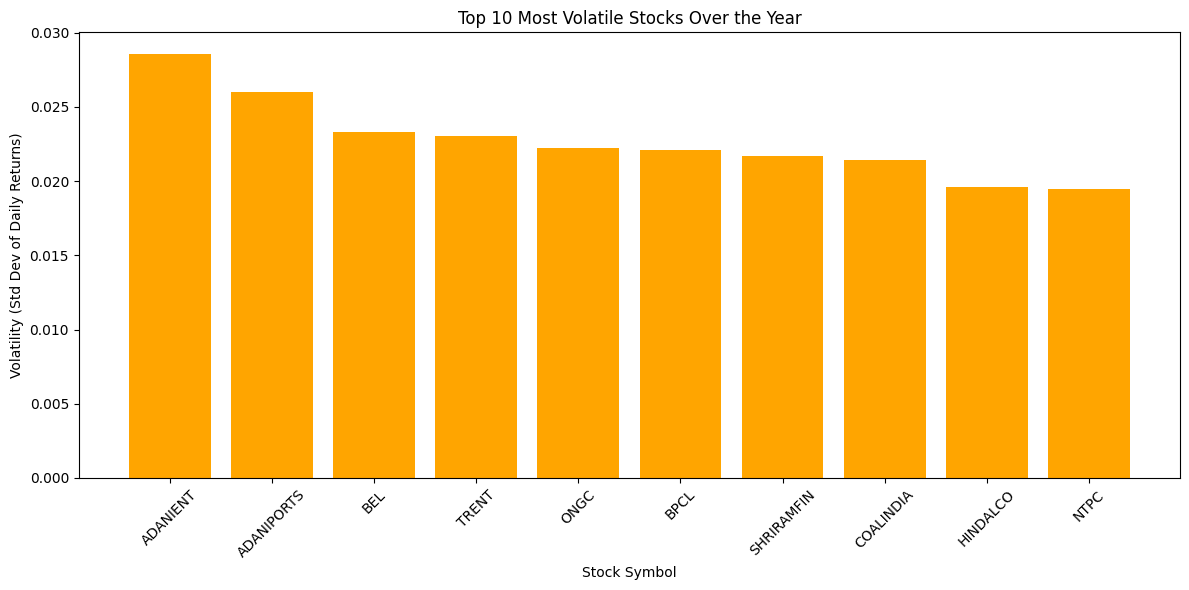

Bar chart saved to: D:\data-driven-stock-analysis\data\processed\top_10_volatile_stocks.png


In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Folder where all processed stock CSVs are stored
processed_folder = r"D:\data-driven-stock-analysis\data\processed"

# Dictionary to hold volatility values
volatility_dict = {}

# Loop through all CSV files in the processed folder
for file in os.listdir(processed_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(processed_folder, file)
        symbol = file.replace(".csv", "")

        try:
            df = pd.read_csv(file_path)

            if 'date' not in df.columns or 'close' not in df.columns:
                print(f"Skipping {symbol} — 'date' or 'close' column missing.")
                continue

            df = df[['date', 'close']].copy()
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df = df.dropna(subset=['date', 'close'])
            df = df.sort_values('date')

            # Calculate daily returns
            df['daily_return'] = df['close'].pct_change()
            volatility = df['daily_return'].std()

            if pd.notna(volatility):
                volatility_dict[symbol] = volatility

        except Exception as e:
            print(f"Error processing {symbol}: {e}")

# Convert to DataFrame
vol_df = pd.DataFrame(list(volatility_dict.items()), columns=['Symbol', 'Volatility'])
vol_df = vol_df.sort_values(by='Volatility', ascending=False).head(10)

# Save CSV
volatility_csv_path = os.path.join(processed_folder, "top_10_volatile_stocks.csv")
vol_df.to_csv(volatility_csv_path, index=False)
print(f"Top 10 volatile stocks saved to: {volatility_csv_path}")

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(vol_df['Symbol'], vol_df['Volatility'], color='orange')
plt.xlabel('Stock Symbol')
plt.ylabel('Volatility (Std Dev of Daily Returns)')
plt.title('Top 10 Most Volatile Stocks Over the Year')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(processed_folder, "top_10_volatile_stocks.png")
plt.savefig(plot_path)
plt.show()

print(f"Bar chart saved to: {plot_path}")


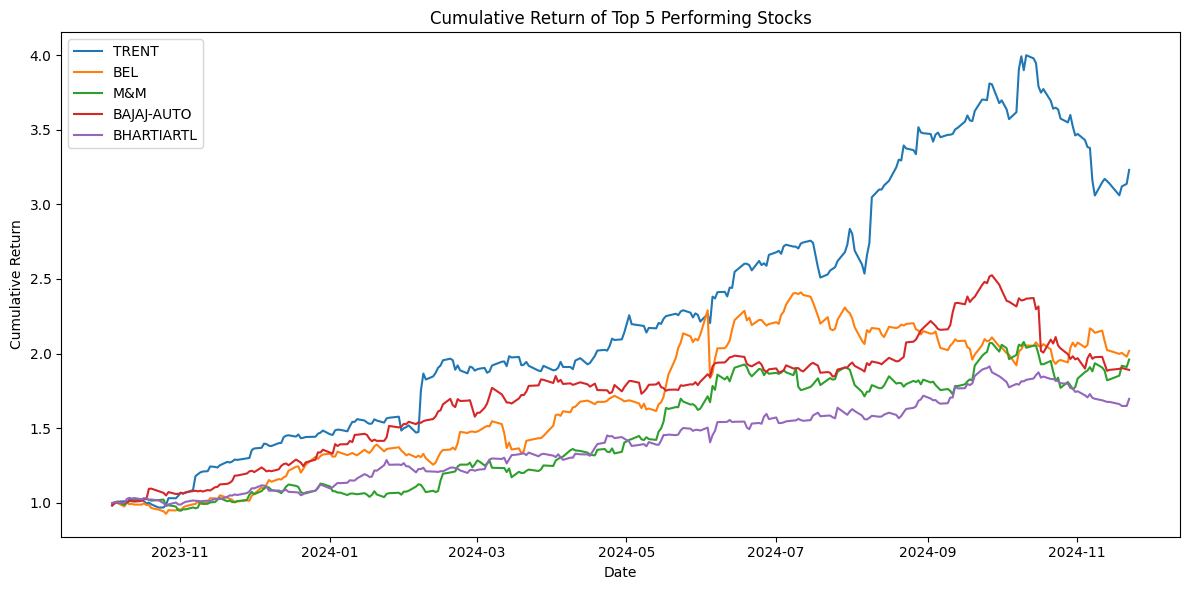

Cumulative return chart saved at: D:\data-driven-stock-analysis\data\processed\top_5_cumulative_returns.png
Cumulative return CSV saved at: D:\data-driven-stock-analysis\data\processed\top_5_cumulative_returns.csv


In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define processed folder
processed_folder = r"D:\data-driven-stock-analysis\data\processed"

# Dictionary to hold DataFrames of cumulative returns
cumulative_returns = {}
final_returns = {}

# Loop through each stock CSV file
for file in os.listdir(processed_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(processed_folder, file)
        symbol = file.replace(".csv", "")

        try:
            df = pd.read_csv(file_path)

            if 'date' not in df.columns or 'close' not in df.columns:
                continue

            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df = df.dropna(subset=['date', 'close'])
            df = df.sort_values('date')

            # Calculate daily return
            df['daily_return'] = df['close'].pct_change()

            # Calculate cumulative return
            df['cumulative_return'] = (1 + df['daily_return']).cumprod()

            # Store cumulative return with date
            cumulative_returns[symbol] = df[['date', 'cumulative_return']].dropna()

            # Save final cumulative return
            final_return = df['cumulative_return'].iloc[-1] if not df['cumulative_return'].isna().all() else 0
            final_returns[symbol] = final_return

        except Exception as e:
            print(f"Error in {symbol}: {e}")

# Convert final return dict to DataFrame
final_df = pd.DataFrame(list(final_returns.items()), columns=['Symbol', 'FinalCumulativeReturn'])
final_df = final_df.sort_values(by='FinalCumulativeReturn', ascending=False)

# Get top 5 symbols
top_5_symbols = final_df.head(5)['Symbol'].tolist()

# Plot cumulative return for top 5
plt.figure(figsize=(12, 6))
for symbol in top_5_symbols:
    data = cumulative_returns[symbol]
    plt.plot(data['date'], data['cumulative_return'], label=symbol)

plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Return of Top 5 Performing Stocks")
plt.legend()
plt.tight_layout()

# Save plot
plot_path = os.path.join(processed_folder, "top_5_cumulative_returns.png")
plt.savefig(plot_path)
plt.show()
print(f"Cumulative return chart saved at: {plot_path}")

# Save CSV for top 5 cumulative returns (merged for inspection)
combined_df = pd.DataFrame()
for symbol in top_5_symbols:
    temp_df = cumulative_returns[symbol].copy()
    temp_df = temp_df.rename(columns={"cumulative_return": symbol})
    if combined_df.empty:
        combined_df = temp_df
    else:
        combined_df = pd.merge(combined_df, temp_df, on='date', how='outer')

# Sort by date and save
combined_df = combined_df.sort_values('date')
csv_path = os.path.join(processed_folder, "top_5_cumulative_returns.csv")
combined_df.to_csv(csv_path, index=False)
print(f"Cumulative return CSV saved at: {csv_path}")


In [25]:
import pandas as pd

data = {
    'symbol': ['RELIANCE', 'TCS', 'INFY', 'HDFCBANK', 'ICICIBANK', 'HINDUNILVR', 'LT', 'BHARTIARTL', 'ITC', 'KOTAKBANK'],
    'sector': ['Energy', 'IT', 'IT', 'Financials', 'Financials', 'Consumer Goods', 'Infrastructure', 'Telecom', 'Consumer Goods', 'Financials']
}

sector_df = pd.DataFrame(data)
sector_df.to_csv(r'D:\data-driven-stock-analysis\data\sector_data.csv', index=False)

print(" Sector file created successfully.")


 Sector file created successfully.


 Sector returns calculated. Plotting bar chart...


C:\Users\ALDO\AppData\Local\Temp\ipykernel_10736\3633468608.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sector_returns, x='sector', y='yearly_return', palette='coolwarm')


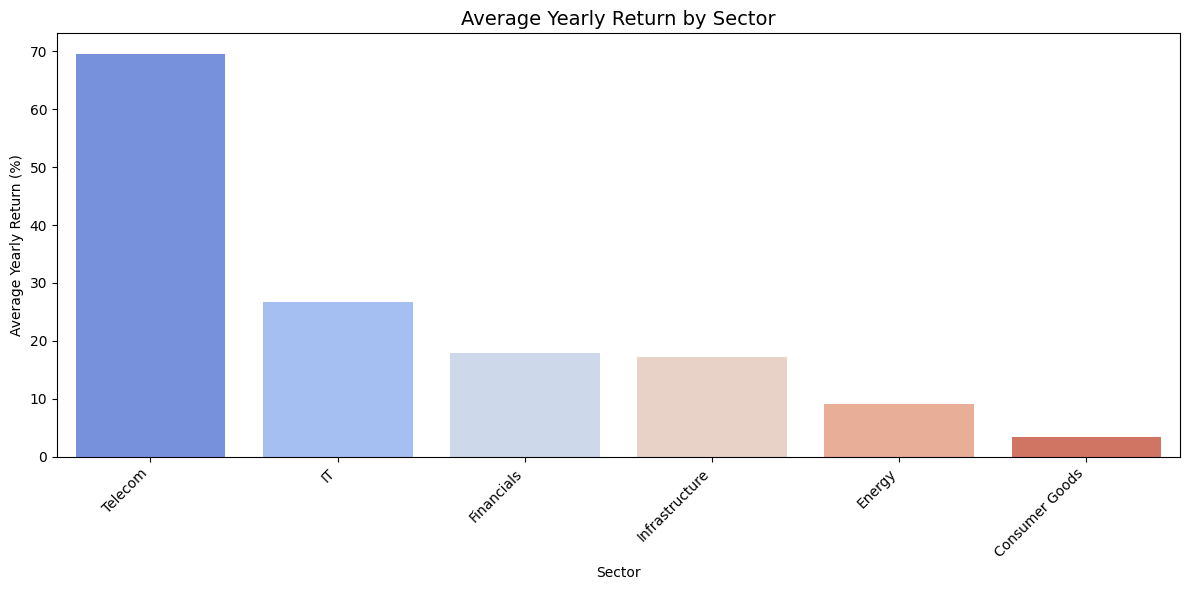

In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
data_dir = r'D:\data-driven-stock-analysis\data\processed'
sector_file = r'D:\data-driven-stock-analysis\data\sector_data.csv' 
output_csv = os.path.join(data_dir, 'sector_wise_returns.csv')

# 1. Load Sector Mapping
if not os.path.exists(sector_file):
    print(f" Sector file not found: {sector_file}")
    sector_df = None
else:
    sector_df = pd.read_csv(sector_file)
    sector_df.columns = sector_df.columns.str.strip().str.lower()
    sector_df = sector_df[['symbol', 'sector']]
    sector_df['symbol'] = sector_df['symbol'].str.upper().str.replace('.NS', '', regex=False)

# 2. Compute Returns per Symbol
returns = []

for file in os.listdir(data_dir):
    if file.endswith('.csv') and file != 'sector_wise_returns.csv':
        symbol = file.replace('.csv', '').upper().replace('.NS', '')  # Clean symbol
        try:
            df = pd.read_csv(os.path.join(data_dir, file))
            if 'close' in df.columns and 'date' in df.columns:
                df = df[df['close'].notna()].sort_values(by='date')
                if len(df) >= 2:
                    start_price = df.iloc[0]['close']
                    end_price = df.iloc[-1]['close']
                    yearly_return = ((end_price - start_price) / start_price) * 100
                    returns.append({'symbol': symbol, 'yearly_return': yearly_return})
        except Exception as e:
            print(f"Error processing {symbol}: {e}")

returns_df = pd.DataFrame(returns)

# 3. Merge and Analyze Sector Returns
if sector_df is not None and not returns_df.empty:
    merged = pd.merge(returns_df, sector_df, on='symbol', how='inner')
    
    if not merged.empty:
        sector_returns = merged.groupby('sector')['yearly_return'].mean().reset_index()
        sector_returns = sector_returns.sort_values(by='yearly_return', ascending=False)
        sector_returns.to_csv(output_csv, index=False)

        print(" Sector returns calculated. Plotting bar chart...")

        plt.figure(figsize=(12, 6))
        sns.barplot(data=sector_returns, x='sector', y='yearly_return', palette='coolwarm')
        plt.title('Average Yearly Return by Sector', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Average Yearly Return (%)')
        plt.xlabel('Sector')
        plt.tight_layout()
        plt.show()
    else:
        print("No matching symbols between return data and sector file. Check symbol formats.")
else:
    print("Either sector file missing or return data is empty.")


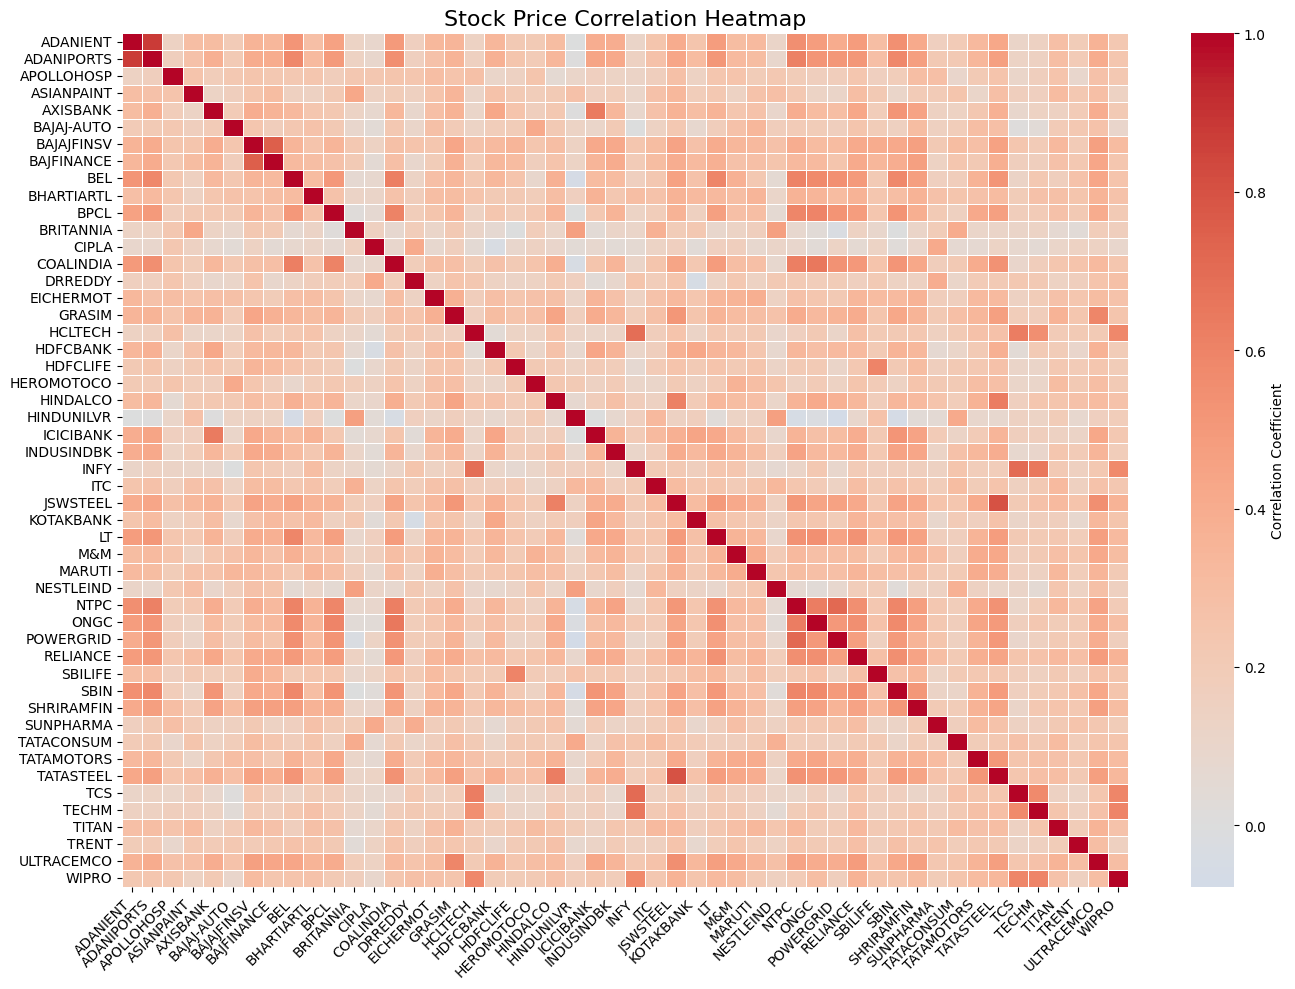

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Directory containing individual stock CSVs
data_dir = r'D:\data-driven-stock-analysis\data\processed'

# 2. Dictionary to store each stock's percentage change
returns_dict = {}

for file in os.listdir(data_dir):
    if file.endswith('.csv') and file != 'sector_wise_returns.csv':
        symbol = file.replace('.csv', '').upper().replace('.NS', '')
        file_path = os.path.join(data_dir, file)
        try:
            df = pd.read_csv(file_path)
            if 'date' in df.columns and 'close' in df.columns:
                df = df[['date', 'close']].dropna()
                df = df.sort_values('date')
                df['pct_change'] = df['close'].pct_change()
                returns_dict[symbol] = df['pct_change'].values
        except Exception as e:
            print(f"Error processing {symbol}: {e}")

# 3. Create a DataFrame from the returns dictionary
returns_df = pd.DataFrame(returns_dict)

# 4. Drop rows with NaNs (result of pct_change)
returns_df = returns_df.dropna()

# 5. Compute correlation matrix
correlation_matrix = returns_df.corr()

# 6. Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5, cbar_kws={"label": "Correlation Coefficient"})
plt.title('Stock Price Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


C:\Users\ALDO\AppData\Local\Temp\ipykernel_10736\1970603297.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x='monthly_return', y='symbol', palette='Greens_r')
C:\Users\ALDO\AppData\Local\Temp\ipykernel_10736\1970603297.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom5, x='monthly_return', y='symbol', palette='Reds')
C:\Users\ALDO\AppData\Local\Temp\ipykernel_10736\1970603297.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x='monthly_return', y='symbol', palette='Greens_r')
C:\Users\ALDO\AppDat

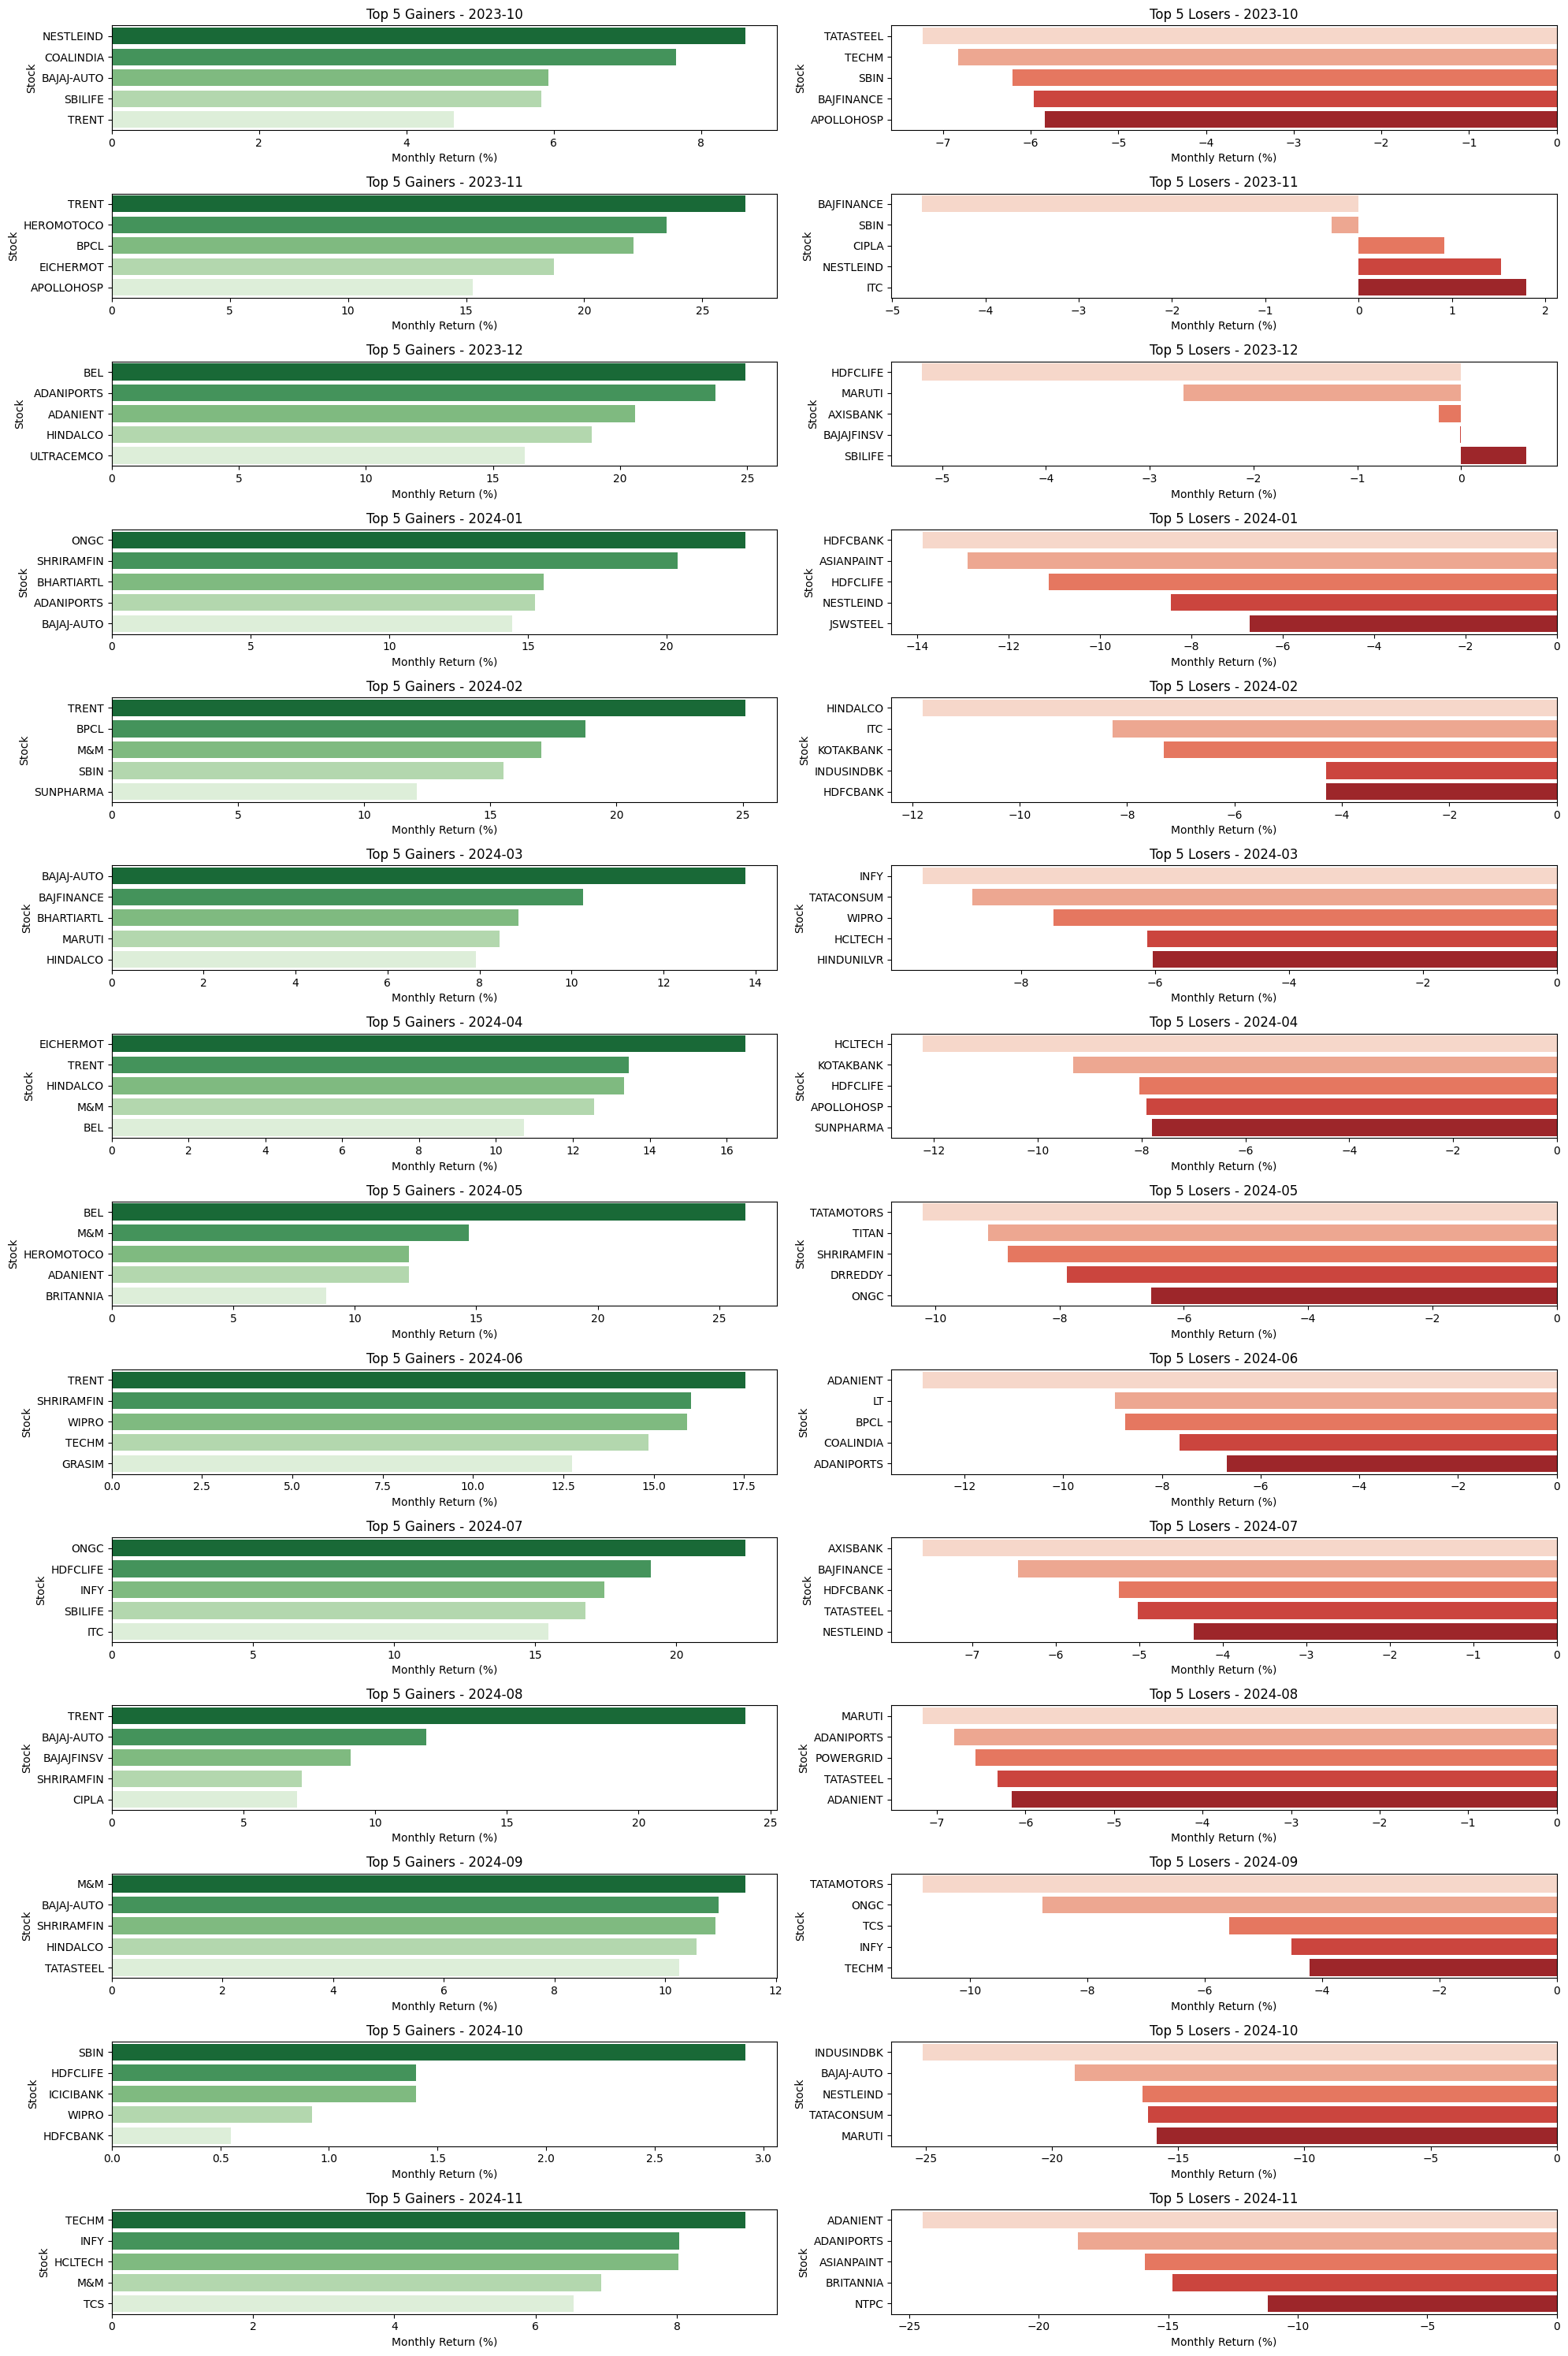

In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
data_dir = r'D:\data-driven-stock-analysis\data\processed'

# Collect monthly returns for each stock
monthly_returns_list = []

for file in os.listdir(data_dir):
    if file.endswith('.csv') and file != 'sector_wise_returns.csv':
        symbol = file.replace('.csv', '').upper().replace('.NS', '')
        file_path = os.path.join(data_dir, file)
        
        try:
            df = pd.read_csv(file_path)
            if 'date' in df.columns and 'close' in df.columns:
                df['date'] = pd.to_datetime(df['date'])
                df = df[['date', 'close']].dropna()
                df = df.sort_values('date')
                df['month'] = df['date'].dt.to_period('M')
                grouped = df.groupby('month')

                for month, group in grouped:
                    if len(group) >= 2:
                        start_price = group.iloc[0]['close']
                        end_price = group.iloc[-1]['close']
                        monthly_return = ((end_price - start_price) / start_price) * 100
                        monthly_returns_list.append({
                            'month': str(month),
                            'symbol': symbol,
                            'monthly_return': monthly_return
                        })
        except Exception as e:
            print(f"Error processing {symbol}: {e}")

# Create DataFrame
monthly_returns_df = pd.DataFrame(monthly_returns_list)

# Ensure months are sorted properly
monthly_returns_df['month'] = pd.to_datetime(monthly_returns_df['month'])

# Set up plots
months_sorted = sorted(monthly_returns_df['month'].dt.strftime('%Y-%m').unique())
plt.figure(figsize=(20, 30))
plot_idx = 1

for month_str in months_sorted:
    month_data = monthly_returns_df[monthly_returns_df['month'].dt.strftime('%Y-%m') == month_str]
    
    # Top 5 gainers
    top5 = month_data.sort_values(by='monthly_return', ascending=False).head(5)
    
    # Top 5 losers
    bottom5 = month_data.sort_values(by='monthly_return').head(5)

    # Plot Gainers
    plt.subplot(len(months_sorted), 2, plot_idx)
    sns.barplot(data=top5, x='monthly_return', y='symbol', palette='Greens_r')
    plt.title(f'Top 5 Gainers - {month_str}')
    plt.xlabel('Monthly Return (%)')
    plt.ylabel('Stock')
    plot_idx += 1

    # Plot Losers
    plt.subplot(len(months_sorted), 2, plot_idx)
    sns.barplot(data=bottom5, x='monthly_return', y='symbol', palette='Reds')
    plt.title(f'Top 5 Losers - {month_str}')
    plt.xlabel('Monthly Return (%)')
    plt.ylabel('Stock')
    plot_idx += 1

plt.tight_layout()
plt.show()


In [3]:
import pandas as pd

# Step 1: Define the input and output file paths
input_path = "D:/data-driven-stock-analysis/data/Sector_data - Sheet1.csv"
output_path = "D:/data-driven-stock-analysis/data/sector_mapping.csv"

# Step 2: Load the raw sector mapping file
raw_df = pd.read_csv(input_path)

# Step 3: Strip whitespace and convert column names to lowercase
raw_df.columns = raw_df.columns.str.strip().str.lower()

# Step 4: Print the cleaned column names for confirmation
print("✅ Cleaned columns:", raw_df.columns.tolist())

# Step 5: Try to extract only the necessary columns
if 'symbol' in raw_df.columns and 'sector' in raw_df.columns:
    sector_df = raw_df[['symbol', 'sector']].copy()

    # Step 6: Drop rows with missing values in symbol or sector
    sector_df.dropna(subset=['symbol', 'sector'], inplace=True)

    # Step 7: Save the cleaned mapping file
    sector_df.to_csv(output_path, index=False)
    print(f"✅ sector_mapping.csv saved to: {output_path}")
else:
    print("❌ 'symbol' or 'sector' columns not found in CSV.")


✅ Cleaned columns: ['company', 'sector', 'symbol']
✅ sector_mapping.csv saved to: D:/data-driven-stock-analysis/data/sector_mapping.csv
